# (WIP) 06. PyTorch Transfer Learning

In [1]:
import torch
import torchvision

from torch import nn
from torchvision import transforms, datasets
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

# TK - check if running on Google Colab, if so, clone repo and get going_modular scripts, else import as normal (from local)
# TK - Download going modular file in some way to make it usable with the notebook
from going_modular.going_modular import data_setup, engine

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## TK 1. Get data

In [15]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


In [16]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## TK 2. Create Datasets and DataLoaders

In [17]:
# TK - what is happening here? with normalize layer
# TK - Load in data
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])

simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
#     normalize
])

# 
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
  test_dir=test_dir,
  transform=simple_transform,
  batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x133c5fa30>,
 ['pizza', 'steak', 'sushi'])

## TK 3. Making a model

In [18]:
model = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Print a summary
# summary(model, input_shape=(1, 3, 224, 224))

In [19]:
# TK - view the model
# model

In [20]:
# TK - Update the classifier - how is this done?
model.classifier = torch.nn.Linear(1280, 10).to(device)

# Freeze all base layers (the feature extractor in EfficientNet)
for param in model.features.parameters():
    param.requires_grad = False

# Print a summary
# model

## TK 4. Train model

In [21]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
# Train model
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7389 | train_acc: 0.4062 | test_loss: 1.4905 | test_acc: 0.5284
Epoch: 2 | train_loss: 1.0760 | train_acc: 0.6367 | test_loss: 1.2605 | test_acc: 0.6411
Epoch: 3 | train_loss: 0.9269 | train_acc: 0.7305 | test_loss: 0.9970 | test_acc: 0.7434
Epoch: 4 | train_loss: 0.7742 | train_acc: 0.7695 | test_loss: 0.8058 | test_acc: 0.8447
Epoch: 5 | train_loss: 0.6857 | train_acc: 0.7656 | test_loss: 0.7033 | test_acc: 0.8769


In [ ]:
#   0%|          | 0/5 [00:00<?, ?it/s]
# Epoch: 1 | train_loss: 1.6859 | train_acc: 0.4531 | test_loss: 1.2711 | test_acc: 0.4981
# Epoch: 2 | train_loss: 1.0736 | train_acc: 0.5820 | test_loss: 0.9587 | test_acc: 0.5284
# Epoch: 3 | train_loss: 0.9415 | train_acc: 0.6602 | test_loss: 0.7688 | test_acc: 0.8551
# Epoch: 4 | train_loss: 0.7749 | train_acc: 0.8594 | test_loss: 0.7396 | test_acc: 0.8561
# Epoch: 5 | train_loss: 0.6889 | train_acc: 0.7969 | test_loss: 0.6857 | test_acc: 0.8759

## 5. TK - Evaluate model

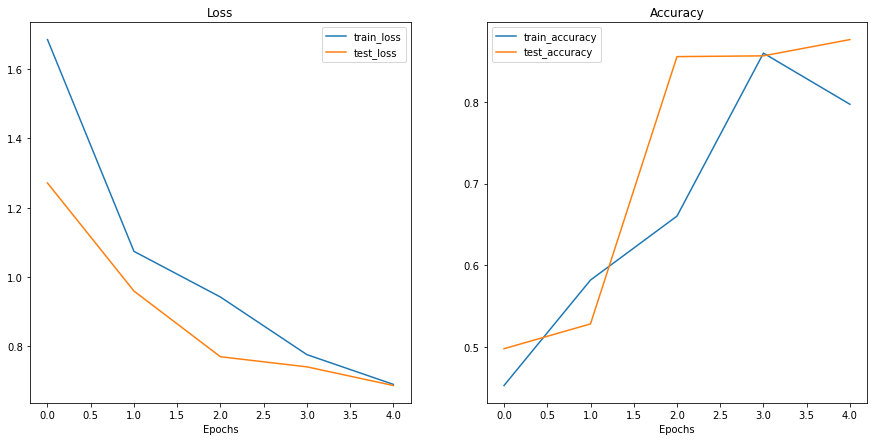

In [11]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## TK - Make predictions with custom images (could use/create `predict.py` from previous section)

## TK - Extensions + Exercises
* Try a different model from PyTorch pretrained models
* Train for longer, what happens?
* Could you add in some data augmentation? What happens then?

## TK - Extra-curriculum
* Check out the PyTorch multi-weights API (still in beta at time of writing, March 2022) - https://pytorch.org/blog/introducing-torchvision-new-multi-weight-support-api/